# Ideas:

Forecast into future (change age at obs)
Forecast rainy next 5 years (change age at obs and prcp)
Forecast change in temp (change age at obs and temp)
Idetify if a specific species it at risk


# 5 Modeling

## 5.0 Introduction

Now that we've got our model established, I want to do some exploring. First, I will load in my full testing and training data and fit the model to the full range of data. I will unfortunately need to do the full imputing, SMOTE (to address imbalanced classes), scaling, and encoding to keep things consistent. 
\
\
Once we have that full sampling prepped, we can fit on it then predict using our *ENTIRE DATAFRAME*. That's a lot of data so let's hope it goes well. From there we can do some mapping and modeling. Should be fun!

## 5.1 Imports

In [23]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTENC

import geopandas as gpd
from shapely.geometry import Point, Polygon

## 5.2 Load and process

### 5.1.0 Load Model

In [3]:
expected_model_version = '1.0'
model_path = '../models/seattle_trees_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

### 5.2.0 Load Data
Load in the raw X and y data we saved at the end of our last step. This is our full 20k sample records.

In [9]:
X = pd.read_csv('../data/data_outputs/X_full_sample.csv')
y = pd.read_csv('../data/data_outputs/y_full_sample.csv')

print(X.shape, y.shape)

(20000, 10) (20000, 1)


In [10]:
#copy X and y to new dataframes
X_full = X.reset_index(drop=True)
y_full = y.reset_index(drop=True)

### 5.2.1 Process Data for Fitting Model

#### 5.2.1.0 Initialized Imputers, Scalers, and Encoder

In [14]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
# ss_scaler = StandardScaler()
# pow_trans = PowerTransformer()
# ohe1 = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #one for our common_name column
# ohe2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #one for our native column

#### 5.2.1.1 Create and Apply Name Grouping Function

In [11]:
def group_categories(df, col, n_limit):
    """ Store categories in df[col] with counts less than the specified n and overwrite the corresponding values in the df with 'Other' """
    groups = df[col]
    group_counts = groups.value_counts()
    mask = groups.isin(group_counts[group_counts<n_limit].index)
    df.loc[mask, col] = 'Other'

In [12]:
#Run group categories on common_name, here using 25
group_categories(X_full, 'common_name', 25)

In [13]:
#View Value Counts
X_full['common_name'].value_counts()

Other                      2883
Red maple                   696
Apple/crabapple             566
Purpleleaf plum variety     565
Norway maple                542
                           ... 
Largeleaf crabapple          26
Emerald sunshine elm         26
Globe norway maple           25
Chinese elm                  25
Profusion crabapple          25
Name: common_name, Length: 148, dtype: int64

#### 5.2.1.2 Imput Missing Values

In [15]:
#Prep for SMOTE, impute missing and group categorical values
#impute missing values
X_full['age_at_obs'] = num_imputer.fit_transform(X_full[['age_at_obs']])
X_full['common_name'] = cat_imputer.fit_transform(X_full[['common_name']])

In [16]:
X_full.shape

(20000, 10)

#### 5.2.1.3 SMOTE X Data to Address Class Imbalance

In [17]:
#View our balance of classes
y_full.value_counts() / y_full.shape[0] * 100

condition_index
4.0                55.325
3.0                24.135
5.0                13.510
2.0                 5.420
1.0                 1.610
dtype: float64

In [18]:
#Use smote
sm = SMOTENC(random_state=42, categorical_features=[0,2])
X_smote, y_smote = sm.fit_resample(X_full, y_full)

In [19]:
#view new resampled distribution
print(y_smote.value_counts() / y_smote.shape[0] * 100)

print(X_smote.shape)

condition_index
1.0                20.0
2.0                20.0
3.0                20.0
4.0                20.0
5.0                20.0
dtype: float64
(55325, 10)


#### 5.2.1.4 Scale Numerical Values

In [321]:
#Standard Scaler
X_smote[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']] = ss_scaler.fit_transform(X_smote[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']])

#Power Transformer
X_smote[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.fit_transform(X_smote[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])


In [322]:
X_smote.head()

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal
0,Norwegian sunset maple,1.001507,introduced,0.351846,0.293119,-1.626061,0.576894,-0.767596,1.283766,-1.212323
1,Red maple,1.273186,introduced,0.628893,0.717425,-0.707730,-0.994286,-1.326386,-0.784582,0.770351
2,Paperbark maple,-1.156845,introduced,-1.550908,-1.389654,-0.097643,-0.994286,0.911477,-0.784582,0.770351
3,Cleveland norway maple,1.188151,introduced,-0.407873,0.868185,-1.212498,-0.994286,-0.628394,1.283766,-1.212323
4,Other,-0.741043,no_info,-2.177863,0.918547,0.795283,1.517000,0.496514,1.283766,-1.212323


#### 5.2.1.5 Encode Categorical Variables

In [323]:
#reset index to create clean join after encoding
X_smote.reset_index(drop=True, inplace=True)

#transform our common_name field with ohe and put into dataframe
X_name = ohe1.fit_transform(X_smote[['common_name']])
name_df = pd.DataFrame(X_name, columns=ohe1.categories_[0]) #indexing 0 here to grab only the column names

#transform our native field with ohe and put into dataframe
X_native = ohe2.fit_transform(X_smote[['native']])
native_df = pd.DataFrame(X_native, columns=ohe2.categories_[0])

#concat these two dataframes back into X_res and X_test and create new dataframe, dropping original categorical fields
X_smote_scaled_coded = pd.concat([X_smote, name_df, native_df], axis=1)

#drop original categorical fields
X_smote_scaled_coded.drop(columns=['common_name', 'native'], inplace=True)

In [324]:
#review shape of created variables
print(X_smote.shape,name_df.shape,native_df.shape)
print(X_smote_scaled_coded.shape)
print(y_smote.shape)

(55325, 10) (55325, 264) (55325, 3)
(55325, 275)
(55325, 1)


### 5.2.2 Fit Model on Our Full Data Sample

#### 5.2.2.0 Setup Model

We'll use the same parameters as our final model from pre-processing. I didn't end up saving the model and importing due to the large size.

In [325]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=True, random_state=42)

#### 5.2.2.1 Fit on Full 20k Sample

In [22]:
model.fit(X_smote, y_smote)#.values.ravel()) #values.ravel will flatted the array.

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['common_name', 'native']),
                                                 ('numericals_std',
                                                  Pipeline(steps=[('imputer_num_std',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler...
                                                                   StandardScaler())]),
                                                  ['age_at_obs',
                                                   'norm_prcp_mm_total',
                                                   'temp_avg_normal',
                                                   'prcp_mm_normal']),
                                                 ('numbericals_pwr',
                                                  Pipeline(steps=[('imputer_num_pwr',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler_pwr',
                                                                   PowerTransformer())]),
                                                  ['diameter_breast_height_CM',
                                                   'norm_snow_mm_total',
                                                   'distance_between',
                                                   'adj_reports'])])),
                ('clf',
                 RandomForestClassifier(max_depth=25, n_estimators=175))])

#### 5.2.2.2 View Classification Result

In [26]:
print(f"""Recall on training data: {recall_score(model.predict(X_smote), y_smote, average='macro'):.2f}""")
print("Classification Report for Training Data")
print(classification_report(y_smote, model.predict(X_smote)))

Recall on training data: 0.94
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98     11065
         2.0       0.97      0.94      0.96     11065
         3.0       0.94      0.91      0.92     11065
         4.0       0.90      0.91      0.90     11065
         5.0       0.91      0.96      0.94     11065

    accuracy                           0.94     55325
   macro avg       0.94      0.94      0.94     55325
weighted avg       0.94      0.94      0.94     55325



Now that we've added in our full train and test set, I'm noticing our model is really accurate on the 1s and 2s when SMOTE-ed. Some further tuning might be helpful to make it more accurate on the more common classes, but I will leave it for now. We can move onto applying this model to our full data set. Woohoo!

## 5.3 Apply Model to Full Data

### 5.3.1 Load Full Data

In [27]:
seattle_trees_explored = pd.read_csv('../data/data_outputs/seattle_trees_explored_full.csv')


seattle_trees_explored.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,237,1071.925479,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,237,1071.925479,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,237,1071.925479,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3


In [28]:
seattle_trees_explored.shape

(162080, 25)

In [29]:
#Drop fields down to match training data
#drop our columns that are reference from climate dataset and the original condition column (which we used to create our target index feature)
seattle_trees_all = seattle_trees_explored.drop(columns=['nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'condition', 'planted_date','most_recent_observation','tree_id','long_trees','lat_trees','temp_min_normal','temp_max_normal','temp_range_normal']) #also drop some of the climate normals fields since they don't add anything

In [30]:
seattle_trees_all.shape

(162080, 11)

#### 5.3.1.1 Split Dependent and Independent Variables

In [31]:
seattle_X = seattle_trees_all.drop(columns='condition_index')
seattle_y = seattle_trees_all['condition_index']

### 5.3.2 Pre-Process Data

#### 5.3.2.0 Group Name Categories

In [32]:
#Run group categories on common_name, here using 10 since the data is larger
group_categories(seattle_X, 'common_name', 10)

#### 5.3.2.1 Impute Missing Values

In [33]:
#impute missing values
seattle_X['age_at_obs'] = num_imputer.transform(seattle_X[['age_at_obs']])
seattle_X['common_name'] = cat_imputer.transform(seattle_X[['common_name']])

In [34]:
seattle_X.shape

(162080, 10)

### 5.3.3 Run Model on Full Seattle Data And Review Results

#### 5.3.3.0 Predict Using Model

In [35]:
#predict using tune model
y_pred = model.predict(seattle_X)

print(f'Accuracy on full data: {accuracy_score(y_pred, seattle_y):.2f}')
print("Classification Report for Full Data")
print(classification_report(seattle_y, y_pred))
print('----------------------------------------')
print(confusion_matrix(seattle_y, y_pred))

Accuracy on full data: 0.62
Classification Report for Full Data
              precision    recall  f1-score   support

         1.0       0.18      0.24      0.21      2843
         2.0       0.24      0.26      0.25      8479
         3.0       0.49      0.47      0.48     38408
         4.0       0.75      0.71      0.73     89835
         5.0       0.53      0.65      0.59     22515

    accuracy                           0.62    162080
   macro avg       0.44      0.47      0.45    162080
weighted avg       0.62      0.62      0.62    162080

----------------------------------------
[[  696   298   594   814   441]
 [  375  2184  2549  2479   892]
 [ 1012  3054 17908 12635  3799]
 [ 1333  3067 13467 64201  7767]
 [  400   463  2025  4916 14711]]


## 5.4 Map Predicted Data

We'll do some initial mapping here of the results and then get into some modeling/mapping. To do the mapping we'll use geopandas and matplotlib.

### 5.4.1 Load .SHP File

In [340]:
map = gpd.read_file('../resources/Seattle_School_Board_Director_Districts_dirdst_area/Seattle_School_Board_Director_Districts_dirdst_area.shp') #found .shp file by school district. Best I found so far.

<Axes: >

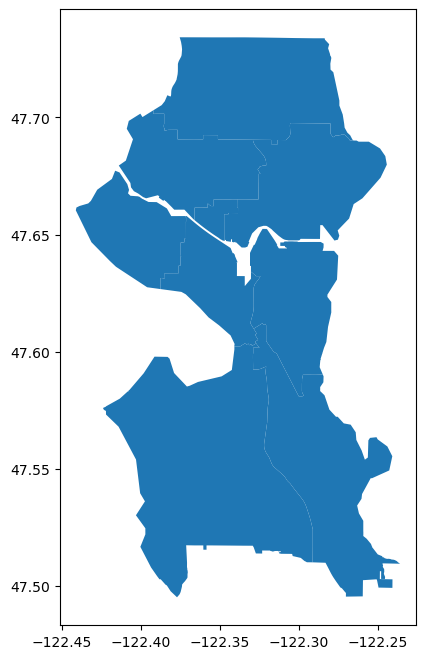

In [341]:
fig, ax = plt.subplots(figsize=(8,8))
map.plot(ax=ax)

### 5.4.2 Prepare Trees Data

#### 5.4.2.0 Load Predicted Variable back into dataframe

We pulled out the geo data before training so now we'll need to add that back in.

In [342]:
#compare shape of y_pred and initial dataframe
print(y_pred.shape)

print(seattle_trees_explored.shape)

print(type(y_pred), type(seattle_trees_explored))

(158004,)
(158004, 25)
<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [343]:
#convert y_pred into a dataframe
prediction = pd.DataFrame(y_pred, columns=['prediction'])

In [344]:
#create new dataframe with predicted variable added
seattle_modeled = pd.concat([seattle_trees_explored, prediction], axis=1,)

In [345]:
seattle_modeled.shape

(158004, 26)

In [346]:
seattle_modeled.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,prediction
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,1071.925479,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,5.0
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,1071.925479,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,5.0
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,1071.925479,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,5.0


#### 5.4.2.1 Create Geo Dataframe

In [347]:
#create points, or single objects that represent lat-long
geometry = [Point(xy) for xy in zip(seattle_modeled['long_trees'], seattle_modeled['lat_trees'])]

geometry[:3]

[<POINT (-122.282 47.635)>, <POINT (-122.319 47.649)>, <POINT (-122.3 47.638)>]

In [348]:
#create coordinate reference system
crs = {'init':'epsg:4326'}

In [349]:
#setup dataframe
geo_df = gpd.GeoDataFrame(seattle_modeled, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,prediction,geometry
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,5.0,POINT (-122.28208 47.63521)
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,5.0,POINT (-122.31895 47.64914)
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,5.0,POINT (-122.29989 47.63786)
3,1991-07-17,2019-04-27,Carriere (lavallei) hawthorn,-122.281439,47.630559,38.10,good,no_info,27.778804,4.0,...,0.0,0.983885,53.2,45.7,60.8,15.0,960.628,4,5.0,POINT (-122.28144 47.63056)
4,1991-07-16,2019-04-27,Evergreen (southern) magnolia,-122.282837,47.627876,15.24,fair,introduced,27.781542,3.0,...,0.0,0.847327,53.2,45.7,60.8,15.0,960.628,5,5.0,POINT (-122.28284 47.62788)


We could drop our lat,long fields,  but don't need to. Now we can map it.

#### 5.4.2.2 Map our Trees, Colored by Our Predcited Variable

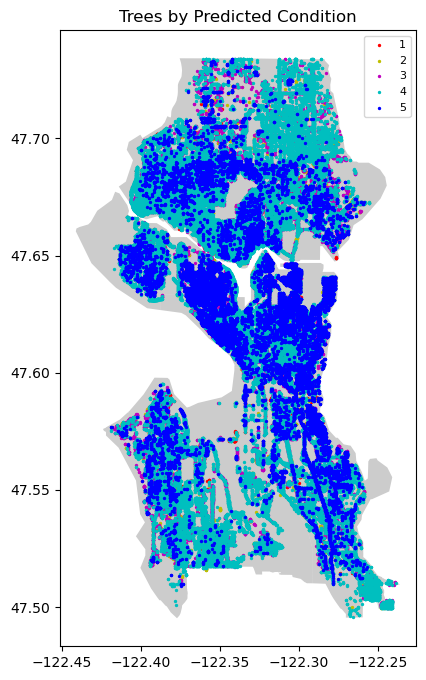

In [350]:
fig, ax = plt.subplots(figsize=(8,8))
map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['prediction'] == 1].plot(ax=ax, 
                                       markersize=2, 
                                       color='r', 
                                       marker='o', 
                                       label='1')
geo_df[geo_df['prediction'] == 2].plot(ax=ax, 
                                       markersize=2, 
                                       color='y', 
                                       marker='o', 
                                       label='2')
geo_df[geo_df['prediction'] == 3].plot(ax=ax, 
                                       markersize=2, 
                                       color='m', 
                                       marker='o', 
                                       label='3')
geo_df[geo_df['prediction'] == 4].plot(ax=ax, 
                                       markersize=2, 
                                       color='c', 
                                       marker='o', 
                                       label='4')
geo_df[geo_df['prediction'] == 5].plot(ax=ax, 
                                       markersize=2, 
                                       color='b', 
                                       marker='o', 
                                       label='5')
plt.legend(prop={'size':8})
plt.title('Trees by Predicted Condition')
plt.show()

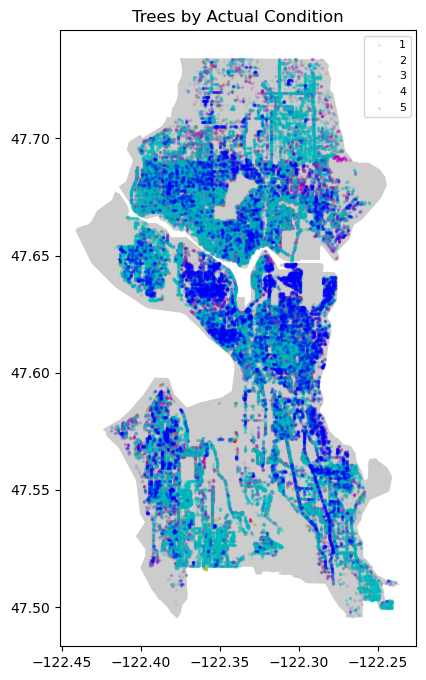

In [351]:
#Now let's check the actual
fig, ax = plt.subplots(figsize=(8,8))
map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['condition_index'] == 1].plot(ax=ax, 
                                       markersize=2, 
                                       color='r', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='1')
geo_df[geo_df['condition_index'] == 2].plot(ax=ax, 
                                       markersize=2, 
                                       color='y', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='2')
geo_df[geo_df['condition_index'] == 3].plot(ax=ax, 
                                       markersize=2, 
                                       color='m', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='3')
geo_df[geo_df['condition_index'] == 4].plot(ax=ax, 
                                       markersize=2, 
                                       color='c', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='4')
geo_df[geo_df['condition_index'] == 5].plot(ax=ax, 
                                       markersize=2, 
                                       color='b', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='5')
plt.legend(prop={'size':8})
plt.title('Trees by Actual Condition')
plt.show()


## 5.5 Modeling

### 5.5.0 Quasi-Model: View Actual vs. Predicted on Map

We can add a field of if the actual and predicted match and then graph.

In [352]:
#Create copy of geo_df
act_v_pred = geo_df.reset_index(drop=True)

In [353]:
#add act_v_pred column
act_v_pred['matches'] = act_v_pred['condition_index'] == act_v_pred['prediction']

In [354]:
act_v_pred.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,prediction,geometry,matches
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,0.947927,53.2,45.7,60.8,15.0,960.628,1,5.0,POINT (-122.28208 47.63521),True
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,3.367105,53.2,45.7,60.8,15.0,960.628,2,5.0,POINT (-122.31895 47.64914),False
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,1.145690,53.2,45.7,60.8,15.0,960.628,3,5.0,POINT (-122.29989 47.63786),True


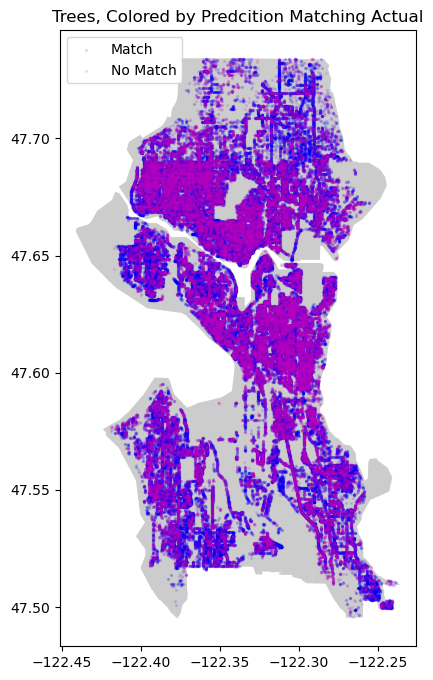

In [355]:
fig, ax = plt.subplots(figsize=(8,8))
map.plot(ax=ax, alpha=0.4, color='grey')
act_v_pred[act_v_pred['matches'] == True].plot(ax=ax, 
                                       markersize=2, 
                                       color='b', 
                                       marker='o', 
                                       label='Match',
                                       alpha=0.1)
act_v_pred[act_v_pred['matches'] == False].plot(ax=ax, 
                                       markersize=2, 
                                       color='m', 
                                       marker='o', 
                                       label='No Match',
                                       alpha=0.1)

plt.legend(prop={'size':10})
plt.title('Trees, Colored by Predcition Matching Actual')
plt.show()

### 5.5.1 Automate Pre-Processing Steps for Easier Modeling

I plan to create new dataframes and run a few models, so I will try to automate as much as possible.

In [356]:
# Create copy of dataframe
X_model_test = seattle_trees_all.drop(columns='condition_index')
y_model_test = seattle_trees_all['condition_index']

#### 5.5.1.1 Define Functions for Processing Steps

Impute, Transform, Encode

In [357]:
def impute(x_df):
    x_df['age_at_obs'] = num_imputer.transform(x_df[['age_at_obs']])
    x_df['common_name'] = cat_imputer.transform(x_df[['common_name']])
    return x_df

In [358]:
def scale(x_df):
    #Standard Scaler
    x_df[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']] = ss_scaler.transform(x_df[['age_at_obs','norm_prcp_mm_total', 'temp_avg_normal','prcp_mm_normal']])

    #Power Transformer
    x_df[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']] = pow_trans.transform(x_df[['diameter_breast_height_CM', 'norm_snow_mm_total','distance_between','adj_reports']])
    return x_df

In [359]:
def encode(x_df):
    """One Hot Encoder, and load results back into dataframe with rest of data"""
    #reset index to create clean join after encoding
    x_df.reset_index(drop=True, inplace=True)

    #transform our common_name field with ohe and put into dataframe
    x_name = ohe1.transform(x_df[['common_name']])
    x_name_df = pd.DataFrame(x_name, columns=ohe1.categories_[0]) #indexing 0 here to grab only the column names

    #transform our native field with ohe and put into dataframe
    x_native = ohe2.transform(x_df[['native']])
    x_native_df = pd.DataFrame(x_native, columns=ohe2.categories_[0])

    #concat these two dataframes back into X_res and X_test and create new dataframe, dropping original categorical fields
    X_scaled_coded = pd.concat([x_df, x_name_df, x_native_df], axis=1)

    #drop original categorical fields
    X_scaled_coded.drop(columns=['common_name', 'native'], inplace=True)

    return X_scaled_coded

#### 5.5.1.2 Test Function on Copied X Data

Try combining all the steps into one function.

In [360]:
def preprocess(x_df, col, n_limit):
    group_categories(x_df, col, n_limit)
    impute(x_df)
    scale(x_df)
    x_processed = encode(x_df)
    return x_processed

In [361]:
#Test grouped function
X_model_test_output = preprocess(X_model_test, 'common_name', 10)


In [362]:
X_model_test_output.shape

(158004, 275)

In [363]:
#predict using tune model
y_pred = model.predict(X_model_test_output)

print(f'Accuracy on training data: {accuracy_score(y_pred, y_model_test):.2f}')
print("Classification Report for Training Data")
print(classification_report(y_model_test, y_pred))
print('----------------------------------------')
print(confusion_matrix(y_model_test, y_pred))

Accuracy on training data: 0.65
Classification Report for Training Data
              precision    recall  f1-score   support

         1.0       0.21      0.28      0.24      2806
         2.0       0.27      0.30      0.28      8268
         3.0       0.53      0.49      0.51     37485
         4.0       0.77      0.75      0.76     87557
         5.0       0.61      0.67      0.64     21888

    accuracy                           0.65    158004
   macro avg       0.48      0.50      0.49    158004
weighted avg       0.65      0.65      0.65    158004

----------------------------------------
[[  775   306   587   809   329]
 [  365  2472  2461  2351   619]
 [  890  2972 18510 12402  2711]
 [ 1321  2978 11789 65814  5655]
 [  343   499  1840  4543 14663]]


#### 5.5.1.3 Create Function For Making a GeoDataFrame

In [364]:
def geo_map(df, long, lat, output_df):
    """Create a geo df by inputing df, target lat-long columns, and what you want your new df to be titled"""
    geometry = [Point(xy) for xy in zip(df[long], df[lat])]
    crs = {'init':'epsg:4326'}
    output_df = gpd.GeoDataFrame(df, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
    return output_df

### 5.5.2 Model -> 25 Year Projection

Leaving all other variables the same, what if we fast-forward the clock 25 years and see the projected condition of our trees.

In [365]:
# Create copy of dataframe
X_model1 = seattle_trees_all.drop(columns='condition_index')
y_model1 = seattle_trees_all['condition_index']

In [366]:
X_model1.head(3)

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal
0,(european) white birch,40.64,introduced,27.765115,237,1071.925479,0.0,0.947927,53.2,960.628
1,Kwanzan flowering cherry,5.08,no_info,27.743212,237,1071.925479,0.0,3.367105,53.2,960.628
2,Japanese snowbell tree,2.54,introduced,27.756901,237,1071.925479,0.0,1.145690,53.2,960.628


In [367]:
#Add 25 years to age_at_obs field
X_model1['age_at_obs'] = X_model1['age_at_obs']+25.0

X_model1.head(3)

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal
0,(european) white birch,40.64,introduced,52.765115,237,1071.925479,0.0,0.947927,53.2,960.628
1,Kwanzan flowering cherry,5.08,no_info,52.743212,237,1071.925479,0.0,3.367105,53.2,960.628
2,Japanese snowbell tree,2.54,introduced,52.756901,237,1071.925479,0.0,1.145690,53.2,960.628


In [368]:
#run preprocessing steps
X_model1_output = preprocess(X_model1, 'common_name', 10)

In [369]:
#predict model
#predict using tune model
y_pred1 = model.predict(X_model1_output)

In [370]:
#convert y_pred to a df and load into initial dataframe
prediction_1 = pd.DataFrame(y_pred1, columns=['25year_pred'])
model1 = pd.concat([seattle_modeled, prediction_1], axis=1).drop(columns=['condition_index', 'prediction']) #dropping the original values and keeping only the new modeled amount

In [371]:
model1.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,nearest_station,...,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,geometry,25year_pred
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,WA-KG-266,...,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,POINT (-122.28208 47.63521),5.0
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,WA-KG-266,...,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,POINT (-122.31895 47.64914),5.0
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,WA-KG-266,...,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,POINT (-122.29989 47.63786),5.0


#### 5.5.2.1 Create Modeled GeoDF

In [372]:
model1_geo = geo_map(model1, 'long_trees', 'lat_trees', 'model1_geo')
model1_geo.head(3)

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,nearest_station,...,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,geometry,25year_pred
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,WA-KG-266,...,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,POINT (-122.28208 47.63521),5.0
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,WA-KG-266,...,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,POINT (-122.31895 47.64914),5.0
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,WA-KG-266,...,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,POINT (-122.29989 47.63786),5.0


#### 5.5.2.2 Visualize Current At-Risk vs. Future At-Risk

I'm now calling our Dead/Dying (1) and Poor (2) and poor conditions at risk.

In [373]:
model1.value_counts

<bound method DataFrame.value_counts of        planted_date most_recent_observation                    common_name  \
0        1991-07-22              2019-04-27         (european) white birch   
1        1991-07-30              2019-04-27       Kwanzan flowering cherry   
2        1991-07-25              2019-04-27         Japanese snowbell tree   
3        1991-07-17              2019-04-27   Carriere (lavallei) hawthorn   
4        1991-07-16              2019-04-27  Evergreen (southern) magnolia   
...             ...                     ...                            ...   
157999   2010-10-06              2019-04-27                  Bigleaf maple   
158000   2000-10-06              2019-04-27               Black cottonwood   
158001   2000-10-06              2019-04-27               Black cottonwood   
158002   2010-10-06              2019-04-27               Black cottonwood   
158003   2000-10-06              2019-04-27               Black cottonwood   

        long_trees  lat

In [374]:
#Store breakdown of at-risk trees
current = seattle_modeled['condition_index'].value_counts() / seattle_modeled.shape[0] * 100
year25 = model1['25year_pred'].value_counts() / model1.shape[0] * 100

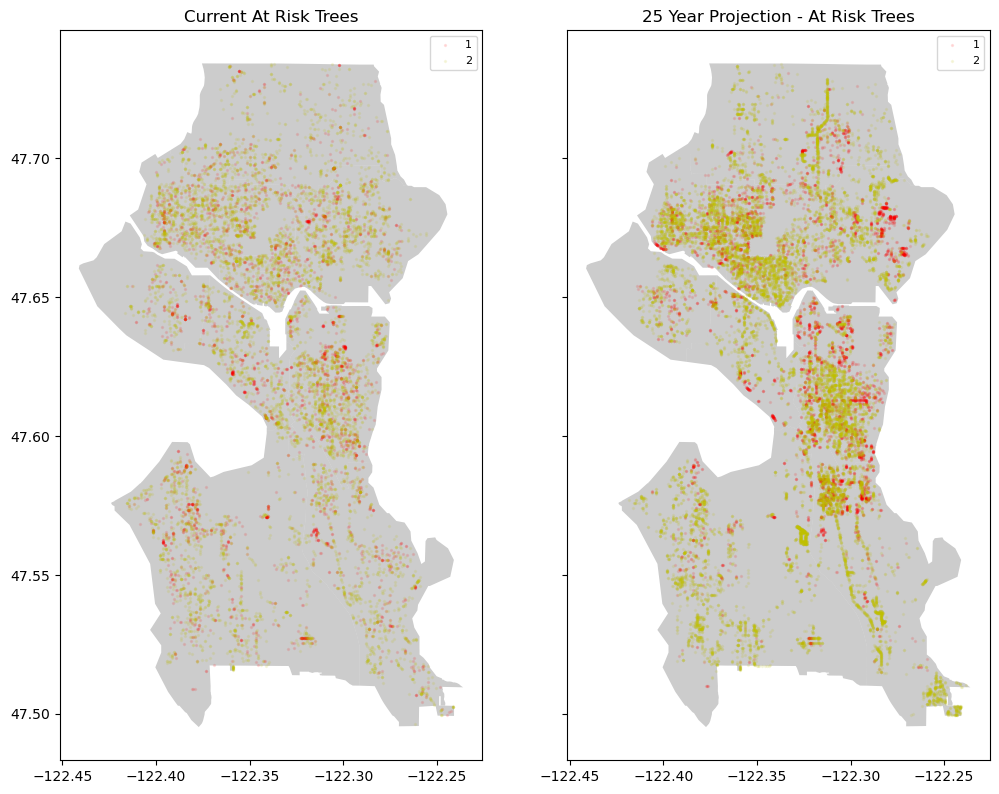

1.0     1.775904
2.0     5.232779
3.0    23.724083
4.0    55.414420
5.0    13.852814
Name: condition_index, dtype: float64
1.0     2.996760
2.0    10.729475
3.0    24.744943
4.0    43.072327
5.0    18.456495
Name: 25year_pred, dtype: float64


In [375]:
#Now let's check the actual
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,12))
ax1 = map.plot(ax=ax1, alpha=0.4, color='grey')
ax2 = map.plot(ax=ax2, alpha=0.4, color='grey')
ax1 = geo_df[geo_df['condition_index'] == 1].plot(ax=ax1, 
                                       markersize=2, 
                                       color='r', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='1')
ax1 = geo_df[geo_df['condition_index'] == 2].plot(ax=ax1, 
                                       markersize=2, 
                                       color='y', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='2')
ax2 = model1_geo[model1_geo['25year_pred'] == 1].plot(ax=ax2, 
                                       markersize=2, 
                                       color='r', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='1')
ax2 = model1_geo[model1_geo['25year_pred'] == 2].plot(ax=ax2, 
                                       markersize=2, 
                                       color='y', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='2')

ax1.legend(prop={'size':8})
ax2.legend(prop={'size':8})
ax1.set_title('Current At Risk Trees')
ax2.set_title('25 Year Projection - At Risk Trees')
plt.show()

print(current.sort_index(ascending=True))
print(year25.sort_index(ascending=True))

**Observations:**
We can see visually the amount of "at-risk" trees increase over that 25 years, and back it up with the disribution. Overall the 1s & 2s increase from about 7% to 13%. But of course, we know the environmental factors won't stay the same over the next 25 years. Let's run a new model and this time increase the temperature by 5%, increase the rainfall by 8%, and increase snowfall by 2%.

### 5.5.3 Model -> 25 Year Projection With Environmental Factors

#### 5.5.3.0 Preprocessing, Fitting

In [376]:
# create copies of original dataframes
X_model2 = seattle_trees_all.drop(columns='condition_index')
y_model2 = seattle_trees_all['condition_index']

In [377]:
#Update predictor variables for future state and increasing environmental factors
#Add 25 years to age_at_obs field
X_model2['age_at_obs'] = X_model2['age_at_obs']+25.0
X_model2['temp_avg_normal'] = X_model2['temp_avg_normal']*1.05
X_model2['prcp_mm_normal'] = X_model2['prcp_mm_normal']*1.05
X_model2['norm_prcp_mm_total'] = X_model2['norm_prcp_mm_total']*1.08
X_model2['norm_snow_mm_total'] = X_model2['norm_snow_mm_total']*1.02

X_model2.head(3)

,common_name,diameter_breast_height_CM,native,age_at_obs,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,prcp_mm_normal
0,(european) white birch,40.64,introduced,52.765115,237,1157.679518,0.0,0.947927,55.86,1008.6594
1,Kwanzan flowering cherry,5.08,no_info,52.743212,237,1157.679518,0.0,3.367105,55.86,1008.6594
2,Japanese snowbell tree,2.54,introduced,52.756901,237,1157.679518,0.0,1.145690,55.86,1008.6594


In [378]:
#run preprocessing function
X_model2_output = preprocess(X_model2, 'common_name', 10)


In [379]:
#predict
y_pred_model2 = model.predict(X_model2_output)

In [380]:
#convert y_pred to a df and load into initial dataframe
prediction_2 = pd.DataFrame(y_pred_model2, columns=['model2_pred'])
model2 = pd.concat([seattle_modeled, prediction_2], axis=1).drop(columns=['condition_index', 'prediction']) #dropping the original values and keeping only the new modeled amount

In [381]:
model2.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,nearest_station,...,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,geometry,model2_pred
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,WA-KG-266,...,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,POINT (-122.28208 47.63521),3.0
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,WA-KG-266,...,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,POINT (-122.31895 47.64914),5.0
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,WA-KG-266,...,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,POINT (-122.29989 47.63786),5.0


In [382]:
#conert to geo_df
model2_geo = geo_map(model2, 'long_trees', 'lat_trees', 'model2_geo')
model2_geo.head(3)

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,nearest_station,...,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,geometry,model2_pred
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,WA-KG-266,...,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,POINT (-122.28208 47.63521),3.0
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,WA-KG-266,...,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,POINT (-122.31895 47.64914),5.0
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,WA-KG-266,...,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,POINT (-122.29989 47.63786),5.0


#### 5.5.3.1 Visualize Future State

In [383]:
#Calculate new distribution
new_env = model2['model2_pred'].value_counts() / model2.shape[0] * 100

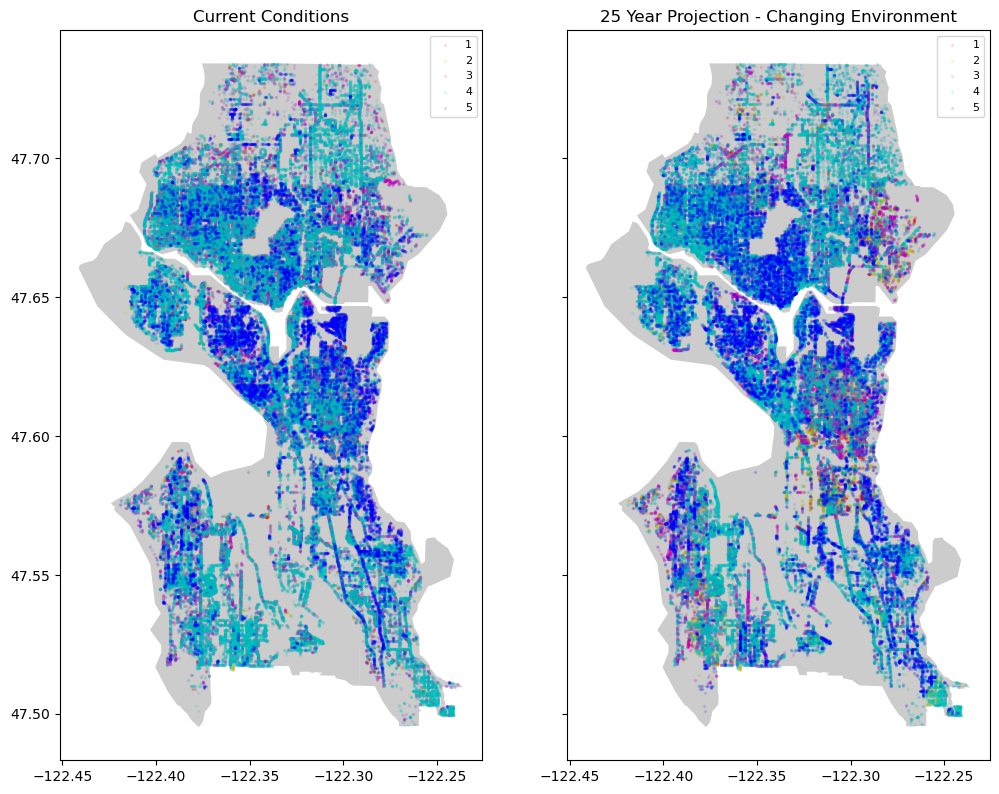

1.0     1.775904
2.0     5.232779
3.0    23.724083
4.0    55.414420
5.0    13.852814
Name: condition_index, dtype: float64
1.0     1.718944
2.0     8.382699
3.0    23.327890
4.0    51.556290
5.0    15.014177
Name: model2_pred, dtype: float64


In [384]:
#Now let's check the actual
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,12))
ax1 = map.plot(ax=ax1, alpha=0.4, color='grey')
ax2 = map.plot(ax=ax2, alpha=0.4, color='grey')
ax1 = geo_df[geo_df['condition_index'] == 1].plot(ax=ax1, 
                                       markersize=2, 
                                       color='r', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='1')
ax1 = geo_df[geo_df['condition_index'] == 2].plot(ax=ax1, 
                                       markersize=2, 
                                       color='y', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='2')
ax1 = geo_df[geo_df['condition_index'] == 3].plot(ax=ax1, 
                                       markersize=2, 
                                       color='m', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='3')
ax1 = geo_df[geo_df['condition_index'] == 4].plot(ax=ax1, 
                                       markersize=2, 
                                       color='c', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='4')
ax1 = geo_df[geo_df['condition_index'] == 5].plot(ax=ax1, 
                                       markersize=2, 
                                       color='b', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='5')
ax2 = model2_geo[model2_geo['model2_pred'] == 1].plot(ax=ax2, 
                                       markersize=2, 
                                       color='r', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='1')
ax2 = model2_geo[model2_geo['model2_pred'] == 2].plot(ax=ax2, 
                                       markersize=2, 
                                       color='y', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='2')
ax2 = model2_geo[model2_geo['model2_pred'] == 3].plot(ax=ax2, 
                                       markersize=2, 
                                       color='m', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='3')
ax2 = model2_geo[model2_geo['model2_pred'] == 4].plot(ax=ax2, 
                                       markersize=2, 
                                       color='c', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='4')
ax2 = model2_geo[model2_geo['model2_pred'] == 5].plot(ax=ax2, 
                                       markersize=2, 
                                       color='b', 
                                       marker='o', 
                                       alpha=0.1,
                                       label='5')

ax1.legend(prop={'size':8})
ax2.legend(prop={'size':8})
ax1.set_title('Current Conditions')
ax2.set_title('25 Year Projection - Changing Environment')
plt.show()

print(current.sort_index(ascending=True))
print(new_env.sort_index(ascending=True))

**Observations:**

Interestingly enough, the environmental changes look like they could have a varying impact, not actually killing as many trees, but moving a larger distribution out of the 'good' category and more into 'poor' or 'excellent.' For our last look, let's identify the species of tree that is the most at risk of the changes coming in the next 25 years.

### 5.5.4 Model -> Analyze by Species

To do this we won't run a new model, but will instead compare our original data to our most recent run at the species group level.

#### 5.5.4.1 Add New Prediction to Original DF

In [385]:
#merge in data
seattle_25year_model = pd.merge(seattle_trees_explored, model2[['tree_id', 'model2_pred']], on='tree_id', how='inner', suffixes=('_act','pred'))

seattle_25year_model.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id,model2_pred
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,1071.925479,0.0,0.947927,53.2,45.7,60.8,15.0,960.628,1,3.0
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,1071.925479,0.0,3.367105,53.2,45.7,60.8,15.0,960.628,2,5.0
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,1071.925479,0.0,1.145690,53.2,45.7,60.8,15.0,960.628,3,5.0


In [386]:
#calculate the 25-year delta
seattle_25year_model['delta25'] = seattle_25year_model['model2_pred'] - seattle_25year_model['condition_index']

In [387]:
seattle_25year = seattle_25year_model[['tree_id','common_name','native','condition_index','model2_pred','delta25']]

seattle_25year.head(3)


,tree_id,common_name,native,condition_index,model2_pred,delta25
0,1,(european) white birch,introduced,5.0,3.0,-2.0
1,2,Kwanzan flowering cherry,no_info,3.0,5.0,2.0
2,3,Japanese snowbell tree,introduced,5.0,5.0,0.0


#### 5.5.4.2 View Top 5 Species at Risk

We'll do this by grouping and viewing the top 5 average drops between actual and 25-year prediction.

In [388]:
#Create grouped dataframe
grouped_25year = seattle_25year.pivot_table(index=['common_name', 'native'], values=['condition_index','model2_pred','delta25'], fill_value=0, margins=True)

In [389]:
#rename columns to be more understandable
grouped_25year.rename(columns={'condition_index': 'avg_actual_condition', 'model2_pred': 'avg_year25_prediction', 'delta25': 'year25_delta'}, inplace=True)

In [390]:
#reset index to make it a flat df
grouped_25year.reset_index(drop=False, inplace=True)

In [391]:
#Calculate species count and create mask for species with at least 50 records
species_count = seattle_25year['common_name'].value_counts()

#create df from counts 
count_df = pd.DataFrame(species_count)
#reset index and rename
count_df = count_df.reset_index(drop=False).rename(columns={'common_name': 'species_count', 'index': 'common_name'})

In [392]:
count_df.head()

,common_name,species_count
0,Red maple,5218
1,Apple/crabapple,4653
2,Norway maple,4510
3,Purpleleaf plum variety,4313
4,(smooth) japanese maple,4193


In [393]:
#merge in species count
condition_delta = pd.merge(grouped_25year, count_df, on='common_name', how='left', suffixes=('_x', '_y'))

In [394]:
#create columns list in order of presentation
cols = ['common_name', 'native', 'species_count', 'avg_actual_condition', 'avg_year25_prediction', 'year25_delta']

#resave df with columns in order
condition_delta = condition_delta[cols].round(1)

In [395]:
#View Top 10, rounded to present in a cleaner fashion
condition_delta[condition_delta['species_count'] >= 50].sort_values(by='year25_delta', ascending=True).reset_index(drop=True).head(10)

,common_name,native,species_count,avg_actual_condition,avg_year25_prediction,year25_delta
0,Cascade snow cherry,no_info,58.0,3.8,1.4,-2.5
1,Accolade elm,no_info,53.0,4.3,3.1,-1.2
2,Forest pansy redbud,introduced,408.0,4.1,3.1,-1.0
3,Spring flurry serviceberry,introduced,90.0,4.0,2.9,-1.0
4,(common) goldenchain,introduced,209.0,3.2,2.4,-0.8
5,Southern (common) catalpa,introduced,270.0,2.7,1.9,-0.8
6,Rocky mt. glow sugar maple,introduced,156.0,4.2,3.4,-0.8
7,Cavalier norway maple,introduced,165.0,3.8,3.0,-0.8
8,Princeton sentry ginkgo,introduced,81.0,3.9,3.2,-0.8
9,Frisia black locust,introduced,57.0,3.9,3.2,-0.7


### 5.5.5 Delta by Native Status

In [398]:
grouped_native = seattle_25year.pivot_table(index=['native'], values=['condition_index','model2_pred','delta25'], fill_value=0, margins=True)

grouped_native.rename(columns={'condition_index': 'avg_actual_condition', 'model2_pred': 'avg_year25_prediction', 'delta25': 'year25_delta'}, inplace=True)

grouped_native.reset_index(drop=False, inplace=True)

#Calculate species count and create mask for species with at least 50 records
native_species = seattle_25year['native'].value_counts()

#create df from counts 
native_count_df = pd.DataFrame(native_species)
#reset index and rename
native_count_df = native_count_df.reset_index(drop=False).rename(columns={'native': 'native_count', 'index': 'native'})

#merge in species count
native_delta = pd.merge(grouped_native, native_count_df, on='native', how='left', suffixes=('_x', '_y'))

native_cols = ['native', 'native_count', 'avg_actual_condition', 'avg_year25_prediction', 'year25_delta']

native_delta = native_delta[native_cols].round(2) #round to present in a cleaner fashion

native_delta.reset_index(drop=True).head(10)

,native,native_count,avg_actual_condition,avg_year25_prediction,year25_delta
0,introduced,116127.0,3.79,3.68,-0.10
1,naturally_occurring,9261.0,3.66,3.92,0.26
2,no_info,32616.0,3.61,3.68,0.07
3,All,NaN,3.74,3.70,-0.05


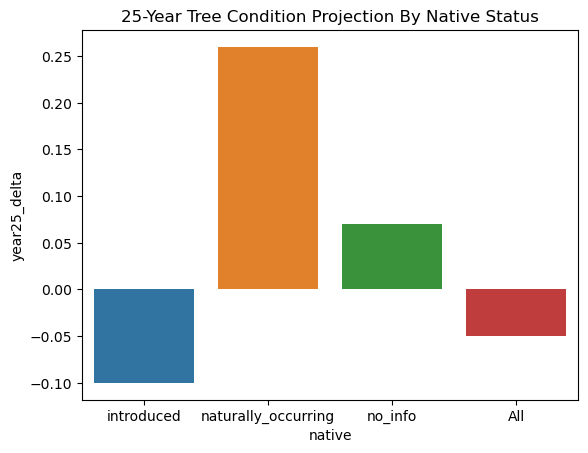

In [399]:
sns.barplot(x='native', y='year25_delta', data=native_delta)

plt.title('25-Year Tree Condition Projection By Native Status')
plt.show()

## 5.6 Conclusion

As we might naturally expect, our introduced (as opposed to naturally occuring) trees are projected to face a bigger decline in conidition over the next 25 years. And since these are the majority of our datapoints, overall our condition is expected to decline slighty. Our naturally occuring are expected to actually improve greatly as our environment may change and warm up. It would be worth some additional research to see how climate and arborists with much more expertise expect.
\
\
Of our species, the Cascade Snow Cherry is expected to have the largest decline in condition. This view is intended to give some target species to intervene with or replace before the condition declines too much. With more time and expertise, grouping into geographic clusters as a new feature and then predicting would be another useful feature to get down to the street or neighborhood level.
\
\
This project took a lot of turns from when I first found the data and make some initial plans. It is far from perfect, but has been a great learning opportunity working with data from varying sources and finding a way to integrate them together.